In [1]:
import pandas as pd
# 构造数据
import faker # 安装：pip install faker

In [2]:
f = faker.Faker('zh-cn')

df = pd.DataFrame({
    '用户': [f.name() for i in range(20000)],
    '购买日期': [f.date_between(start_date='-1y',
    end_date='today') for i in range(20000)],
    '金额': [f.random_int(10, 100) for i in range(20000)]
})

# 数据类型转换
df = df.astype({'购买日期': 'datetime64[ns]'})
# 数据类型
df.dtypes

用户              object
购买日期    datetime64[ns]
金额               int64
dtype: object

In [3]:
df

,用户,购买日期,金额
0,严亮,2023-01-29,72
1,宋冬梅,2023-04-11,38
2,张秀芳,2023-03-26,30
3,叶玉珍,2023-01-13,57
4,刘丹丹,2023-03-23,70
...,...,...,...
19995,谢文,2022-08-01,63
19996,方霞,2022-06-17,90
19997,张桂芝,2022-11-06,58
19998,陆雪,2022-07-24,25


In [4]:
# r 为购买间隔天数
r = (
    df.groupby('用户')
    .apply(lambda x: (pd.Timestamp('today')-x['购买日期'].max()))
    .dt
    .days
)

r

用户
丁丹     113
丁丽      13
丁丽丽      2
丁倩     303
丁健       9
      ... 
龚莉     301
龚雪     159
龚雷     300
龚颖      82
龚飞     104
Length: 9333, dtype: int64

In [5]:
# f 为购买次数，一天多次算一次
f = (
    df.groupby(['用户'])
    .apply(lambda x: x['购买日期'].nunique())
)
f.sort_values()

用户
汪阳      1
章丹      1
窦金凤     1
窦红      1
窦秀珍     1
       ..
王秀梅    19
张华     19
李梅     19
王霞     20
张宇     21
Length: 9333, dtype: int64

In [6]:
# m 为平均每次的购买金额
df.groupby(['用户'])['金额'].sum()

用户
丁丹      81
丁丽      52
丁丽丽    125
丁倩      50
丁健      82
      ... 
龚莉      56
龚雪      89
龚雷      19
龚颖      77
龚飞      22
Name: 金额, Length: 9333, dtype: int64

In [7]:
# 合并RFM
(
    pd.DataFrame({'r': r,'f': f,})
    # m为总金额/购买次数
    .assign(m=lambda x: df.groupby(['用户'])['金额'].sum()/x.f)
)

,r,f,m
用户,,,
丁丹,113,2,40.500000
丁丽,13,1,52.000000
丁丽丽,2,3,41.666667
丁倩,303,1,50.000000
丁健,9,1,82.000000
...,...,...,...
龚莉,301,1,56.000000
龚雪,159,1,89.000000
龚雷,300,1,19.000000


In [8]:
(
    pd.DataFrame({'r': r,'f': f,})
    # m为总金额/购买次数
    .assign(m=lambda x: df.groupby(['用户'])['金额'].sum()/x.f)
    .assign(r_s=lambda x: pd.qcut(x.r, q=3, labels=[3,2,1]))
    .assign(f_s=lambda x: pd.cut(x.f,bins=[0,2,5,float('inf')], labels=[1,2,3],
    right = False))
    .assign(m_s=lambda x: pd.cut(x.m,bins=[0,30,60,float('inf')], labels=[1,2,3],
    right = False))
)

,r,f,m,r_s,f_s,m_s
用户,,,,,,
丁丹,113,2,40.500000,2,2,2
丁丽,13,1,52.000000,3,1,2
丁丽丽,2,3,41.666667,3,2,2
丁倩,303,1,50.000000,1,1,2
丁健,9,1,82.000000,3,1,3
...,...,...,...,...,...,...
龚莉,301,1,56.000000,1,1,2
龚雪,159,1,89.000000,2,1,3
龚雷,300,1,19.000000,1,1,1


In [9]:
(
    pd.DataFrame({'r': r,'f': f,})
    # m为总金额/购买次数
    .assign(m=lambda x: df.groupby(['用户'])['金额'].sum()/x.f)
    .assign(r_s=lambda x: pd.qcut(x.r, q=3, labels=[3,2,1]))
    .assign(f_s=lambda x: pd.cut(x.f,bins=[0,2,5,float('inf')], labels=[1,2,3], right = False))
    .assign(m_s=lambda x: pd.cut(x.m,bins=[0,30,60,float('inf')], labels=[1,2,3], right = False))
    .assign(r_e=lambda x: (x.r_s.astype(int) > x.r_s.astype(int).mean())*1)
    .assign(f_e=lambda x: (x.f_s.astype(int) > x.f_s.astype(int).mean())*1)
    .assign(m_e=lambda x: (x.m_s.astype(int) > x.m_s.astype(int).mean())*1)
)

,r,f,m,r_s,f_s,m_s,r_e,f_e,m_e
用户,,,,,,,,,
丁丹,113,2,40.500000,2,2,2,0,1,0
丁丽,13,1,52.000000,3,1,2,1,0,0
丁丽丽,2,3,41.666667,3,2,2,1,1,0
丁倩,303,1,50.000000,1,1,2,0,0,0
丁健,9,1,82.000000,3,1,3,1,0,1
...,...,...,...,...,...,...,...,...,...
龚莉,301,1,56.000000,1,1,2,0,0,0
龚雪,159,1,89.000000,2,1,3,0,0,1
龚雷,300,1,19.000000,1,1,1,0,0,0


In [10]:
(
    pd.DataFrame({'r': r,'f': f,})
    # m为总金额/购买次数
    .assign(m=lambda x: df.groupby(['用户'])['金额'].sum()/x.f)
    .assign(r_s=lambda x: pd.qcut(x.r, q=3, labels=[3,2,1]))
    .assign(f_s=lambda x: pd.cut(x.f,bins=[0,2,5,float('inf')], labels=[1,2,3], right = False))
    .assign(m_s=lambda x: pd.cut(x.m,bins=[0,30,60,float('inf')], labels=[1,2,3], right = False))
    .assign(r_e=lambda x: (x.r_s.astype(int) > x.r_s.astype(int).mean())*1)
    .assign(f_e=lambda x: (x.f_s.astype(int) > x.f_s.astype(int).mean())*1)
    .assign(m_e=lambda x: (x.m_s.astype(int) > x.m_s.astype(int).mean())*1)
    .assign(label=lambda x: x.r_e*100+x.f_e*10+x.m_e*1)
)

,r,f,m,r_s,f_s,m_s,r_e,f_e,m_e,label
用户,,,,,,,,,,
丁丹,113,2,40.500000,2,2,2,0,1,0,10
丁丽,13,1,52.000000,3,1,2,1,0,0,100
丁丽丽,2,3,41.666667,3,2,2,1,1,0,110
丁倩,303,1,50.000000,1,1,2,0,0,0,0
丁健,9,1,82.000000,3,1,3,1,0,1,101
...,...,...,...,...,...,...,...,...,...,...
龚莉,301,1,56.000000,1,1,2,0,0,0,0
龚雪,159,1,89.000000,2,1,3,0,0,1,1
龚雷,300,1,19.000000,1,1,1,0,0,0,0


<AxesSubplot:xlabel='label'>

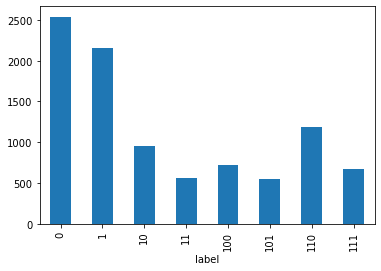

In [11]:
label_names = {111:'重要价值用户',
               110:'一般价值用户',
               101:'重要发展用户',
               100:'一般发展用户',
               11:'重要保持用户',
               10:'一般保持用户',
               1:'重要挽留用户',
               0:'一般挽留用户'}


(
    pd.DataFrame({'r': r,'f': f,})
    # m为总金额/购买次数
    .assign(m=lambda x: df.groupby(['用户'])['金额'].sum()/x.f)
    .assign(r_s=lambda x: pd.qcut(x.r, q=3, labels=[3,2,1]))
    .assign(f_s=lambda x: pd.cut(x.f,bins=[0,2,5,float('inf')], labels=[1,2,3], right = False))
    .assign(m_s=lambda x: pd.cut(x.m,bins=[0,30,60,float('inf')], labels=[1,2,3], right = False))
    .assign(r_e=lambda x: (x.r_s.astype(int) > x.r_s.astype(int).mean())*1)
    .assign(f_e=lambda x: (x.f_s.astype(int) > x.f_s.astype(int).mean())*1)
    .assign(m_e=lambda x: (x.m_s.astype(int) > x.m_s.astype(int).mean())*1)
    .assign(label=lambda x: x.r_e*100+x.f_e*10+x.m_e*1)
    .assign(label_names=lambda x: x.label.map(label_names))
    .groupby('label').count().r.plot.bar()
)